<a href="https://colab.research.google.com/github/Ang3lino/mlnn/blob/master/projects/3/20newsFinalBoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent neural networks for newsgroup documents classification

## Students: Angel Lopez Manriquez

### Description
Recurrent neural networks have been one of the most extensively applied methods to text processing. In comparison to bag-of-words approaches they are able to exploit the sequential
information encoded in the text.

### Objectives
The goal of the project is to implement an RNN-based model (simple RNN and LSTM neurons can
be used) for classifying different documents in 20 classes. The 20-Newsgroups dataset will
be used. It is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

### Content of the notebook
Visualization of the dataset, explanation and a review from it.
Expressing the texts as tensors, removing useless words.
Using word embeddings (glove), taking advantage of a "pre-trained" model.
Defining the architecture of a recurrent neural network.
Validating the model


### Libraries
Numpy and matplotlib as usual.
For the model definition Keras is used rather than tensorflow 2.0 for the high level implementation.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm


# import tensorflow as tf
# import nltk

# from sklearn import metrics
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics
# from sklearn.model_selection import train_test_split


Using TensorFlow backend.


# Data
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

This module contains two loaders. The first one, sklearn.datasets.fetch_20newsgroups, returns a list of the raw texts that can be fed to text feature extractors such as sklearn.feature_extraction.text.CountVectorizer with custom parameters so as to extract feature vectors. The second one, sklearn.datasets.fetch_20newsgroups_vectorized, returns ready-to-use features, i.e., it is not necessary to use a feature extractor.

For teaching purposes, we use sklearn.datasets.fetch_20newsgroups.


In [5]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)  # obtain the train dataset
target_names = twenty_train.target_names  # class label name
texts = twenty_train.data  # list: strings, each element is an email
target = twenty_train.target  # list: int, each integer associated to target_names

In [6]:
i = 1

pprint(f'Data {i}: ')
pprint(texts[i])
pprint(f'Target name {i}: ')
pprint(target_names[target[i]])

'Data 1: '
('From: guykuo@carson.u.washington.edu (Guy Kuo)\n'
 'Subject: SI Clock Poll - Final Call\n'
 'Summary: Final call for SI clock reports\n'
 'Keywords: SI,acceleration,clock,upgrade\n'
 'Article-I.D.: shelley.1qvfo9INNc3s\n'
 'Organization: University of Washington\n'
 'Lines: 11\n'
 'NNTP-Posting-Host: carson.u.washington.edu\n'
 '\n'
 'A fair number of brave souls who upgraded their SI clock oscillator have\n'
 'shared their experiences for this poll. Please send a brief message '
 'detailing\n'
 'your experiences with the procedure. Top speed attained, CPU rated speed,\n'
 'add on cards and adapters, heat sinks, hour of usage per day, floppy disk\n'
 'functionality with 800 and 1.4 m floppies are especially requested.\n'
 '\n'
 'I will be summarizing in the next two days, so please add to the network\n'
 "knowledge base if you have done the clock upgrade and haven't answered this\n"
 'poll. Thanks.\n'
 '\n'
 'Guy Kuo <guykuo@u.washington.edu>\n')
'Target name 1: '
'comp.sy

In [0]:
sns.set(style="darkgrid")


def count_plot(src, col_name='class', vertical=True):
  df = pd.DataFrame(src, columns=[col_name])
  if vertical:
    ax = sns.countplot(data=df, y=col_name, order=df[col_name].value_counts().index)
  else:
    ax = sns.countplot(data=df, x=col_name, order=df[col_name].value_counts().index)

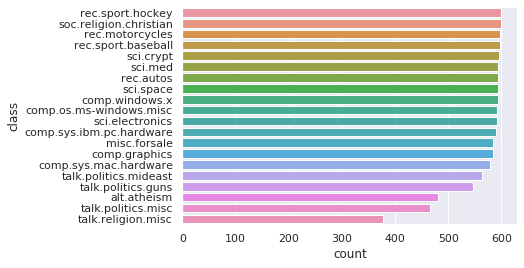

In [8]:

# let's define this df just for plotting
count_plot([target_names[j] for j in target])

## Preprocessing the data

In order to train our neural network we need somehow to express the text in tensor, so that we can train our model. We will tokenize every email, during this process we will remove features from the original text, such as all punctuation or words that are less common.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Remember we have to specify the size of our vocabulary. Words that are less frequent will get removed. 

In [0]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # Generate sequences

In [11]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134142 unique tokens.


Our text is now converted to sequences of numbers. It makes sense to convert some of those sequences back into text to check what the tokenization did to our text. To this end we create an inverse index that maps numbers to words while the tokenizer maps words to numbers.

In [0]:
# Create inverse index mapping numbers to words
inv_index = {v: k for k, v in tokenizer.word_index.items()}

In [13]:
# Print out text again
for w in sequences[i]:
    x = inv_index.get(w)
    print(x,end = ' ')

from guykuo carson u washington edu guy kuo subject si clock poll final call summary final call for si clock reports keywords si acceleration clock upgrade article i d shelley organization university of washington lines 11 nntp posting host carson u washington edu a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with 800 and 1 4 m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven't answered this poll thanks guy kuo guykuo u washington edu 

### Measuring text length

One of the advantages of a recurrent neural network is that we do not need to fix the lenght of the sequence. However, it can be a pretty good idea to restrict sequence lengths for the sake of restricting the time needed to train the network and process sequences. 

In [14]:
seq_len = list(map(len, sequences))
avg = sum(seq_len) / len(sequences)  # Get the average length of a text
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))  # Get the standard deviation of the sequence length
print(f'avg: {avg}\tstd: {std}')
print(f'min length: {min(seq_len), max(seq_len)}')

avg: 302.5179423722821	std: 723.1058289417535
min length: (16, 15365)


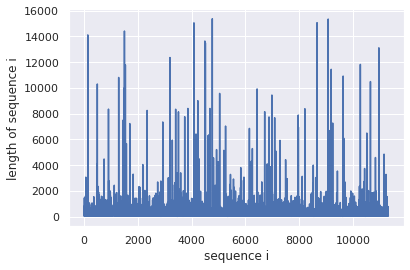

In [15]:
n = len(sequences)
x_label = 'sequence i'
y_label = 'length of sequence i'
src = { x_label: range(n), y_label: seq_len[:n] }  # build a dictionary, X: range(n), y: list of int, the length of a corresponding vector i

df = pd.DataFrame.from_dict(src)  #  convert the dictionary to DataFrame, required for seaborn
# sns.barplot(x=x_label, y=y_label, data=df)
sns.lineplot(x=x_label, y=y_label, data=df)  # let seaborn know exactly the axis from the data
plt.show()

As we appreciate, the average text is about 300 words long. However, the standard deviation is quite large, which suggests some texts are much much longer. For speed purposes we will restrict sequence length to some integer less than 300. We will see we have good accuracy and persormance with this length.

In [0]:
max_length = 100
data = pad_sequences(sequences, maxlen=max_length)

## Turning labels into One-Hot encodings

Labels can quickly be encoded into one-hot vectors with Keras:

In [17]:
from keras.utils import to_categorical

# int -> [int] -> [0 0 ...  1 ... 0]
#                           |
#                          int
labels = to_categorical(np.asarray(target))  
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

Shape of data: (11314, 100)
Shape of labels: (11314, 20)


## Loading GloVe embeddings

As we mentioned, we will use glove embeddings. By the time the notebook was developed (December 2019) we downloaded the file from https://www.kaggle.com/terenceliu4444/glove6b100dtxt . The embeeded vector will have a fixed dimension of 100. The file size is 330 mb.

In [0]:
import os
import requests

In [0]:

def wget(url, fpath):
  r = requests.get(url)
  with open(fpath, 'wb') as f:
      f.write(r.content)

In [20]:
# If you are using Colab and you need to use 
# some file, you need to mount your drive unit. For security purposes it 
# requires a code, after confirmation you can use the file.
try:
  from google.colab import drive  
  drive.mount('/content/drive')
  glove_fpath = "drive/My Drive/gloves/glove.6B.100d.txt"
except:  # the notebooks is not being run from colab, it is assumed the file is in the current directory 
  glove_fpath = "glove.6B.100d.txt"
  if not os.path.exists(glove_fpath):  # no file found, download it
    wget('https://www.kaggle.com/terenceliu4444/glove6b100dtxt/download', glove_fpath)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [21]:

embeddings_index = {}  # We create a dictionary of word -> embedding
with open(glove_fpath) as f:

  # In the dataset, each line represents a new word embedding
  # The line starts with the word and the embedding values follow
  for line in tqdm(f):
      values = line.split()  # split the line, sep=' ' by default
      word = values[0]  # The first value is the word, the rest are the values of the embedding
      embedding = np.asarray(values[1:], dtype='float32')  # Load embedding
      embeddings_index[word] = embedding  # Add embedding to our embedding dictionary
print(f'\nFound {len(embeddings_index)} word vectors.')

400000it [00:14, 27788.74it/s]


Found 400000 word vectors.


In [22]:
all_embs = np.stack(embeddings_index.values())  # Create a matrix of all embeddings
emb_mean = all_embs.mean() # compute mean
emb_std = all_embs.std() # compute standard deviation

print(f'\nmean: {emb_mean}\t std dev: {emb_std}')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):



mean: 0.004451991990208626	 std dev: 0.4081574082374573


In [0]:
embedding_dim = 100 # We use 100 dimensional glove vectors

In [0]:
word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

# create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
for word, i in word_index.items():
    # if we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # if there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

## Transform test dataset
Now we figured out, approximately the length sequence, let us transform the test dataset as we did with the train dataset.

In [0]:

def format_data(texts, target, vocab_size=20000, max_length=100):
    tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) # Generate sequences
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=max_length)
    labels = to_categorical(np.asarray(target))
    return data, labels

In [0]:
test = fetch_20newsgroups(subset='test', shuffle=True)  # fetch the test dataset
data_test = test.data
target_test = test.target

X_test, y_test = format_data(data_test, target_test)

In [27]:
print(f'|X|: {len(X_test)} |y|: {len(y_test)}')

|X|: 7532 |y|: 7532


## Using the LSTM and GRU layer

In Keras, the LSTM layer can be used in exactly the same way as the ``SimpleRNN``. It only takes the size of the layer as an input, much like a dense layer. An LSTM layer returns only the last output of the sequence by default. 

It is important to note we cannot use a simple RNN to solve this task due to the length of each sequence.

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, GRU

import time

In [0]:
def Model(rnn_layer='gru', recurrent_dropout=0.0, nclasses=20):
  ''' Define the model. According to rnn_layer parameter we define a disntinct rnn layer.'''
  model = Sequential()  # instantiate the classic sequential model
  model.add(Embedding(vocab_size,   # vocabulary size
                      embedding_dim,   # embedding dimension
                      input_length=max_length,  
                      weights=[embedding_matrix],   # pass the weights obtained previously from the Glove File
                      trainable=False))  # we don't need to train it again
  if rnn_layer == 'gru': model.add(GRU(128, recurrent_dropout=recurrent_dropout))
  else: model.add(LSTM(128, recurrent_dropout=recurrent_dropout))
  model.add(Dense(nclasses))
  model.add(Activation('softmax'))  
  return model  # return the model if needed

def plot_result(history):
  '''Plot the loss and accuracy of the model, just provide the value returned by model.fit()
  '''
  plt.title('Loss')  
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  plt.title('Accuracy')
  plt.plot(history.history['acc'], label='train')
  plt.plot(history.history['val_acc'], label='test')
  plt.legend()
  plt.show()

In [0]:

def plot_confusion_matrix(model, X, y, ticklabels):
  y_pred = model.predict_classes(X)  # predict the class. Same as np.argmax(model.predict(X))
  conf_mat = confusion_matrix(y, y_pred)  # create the confusion matrix
  
  # create the plot
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=ticklabels, yticklabels=ticklabels)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  
  # print f1_score, average as weighted. Best value at 1 and worst score at 0
  print('F1 score: ', f1_score(target, y_pred, average='weighted'))

In [0]:
def evaluate_model(X_train, y_train, X_test, y_test, rnn_layer='gru', 
                   recurrent_dropout=0.0, nepochs=4):
  model = Model(rnn_layer)  # pass the rnn layer to be used
  print(model.summary())  # print the architecture of the model
  # loss='categorical_crossentropy',
  # loss='binary_crossentropy',  
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  start = time.time()
  hist = model.fit(X_train, y_train, validation_split=0.2, epochs=nepochs)  # fit the model and obtain the number of epochs
  print(f'\n[+]Time required for training the model: {time.time() - start} sec. \n\n')   
  plot_result(hist)
  accr = model.evaluate(X_test, y_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  plot_confusion_matrix(model, data, target, target_names)
  return model










Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
Total params: 2,119,828
Trainable params: 119,828
Non-trainable params: 2,000,000
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9051 samples, validate on 2263 samples
Epoch 1/4
9051/9051 [==============================] - 39s 4ms/step - loss: 

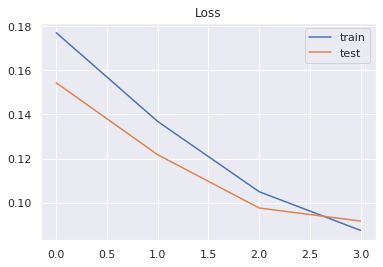

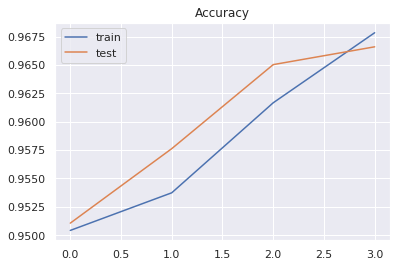

7532/7532 [==============================] - 7s 879us/step
Test set
  Loss: 0.270
  Accuracy: 0.943


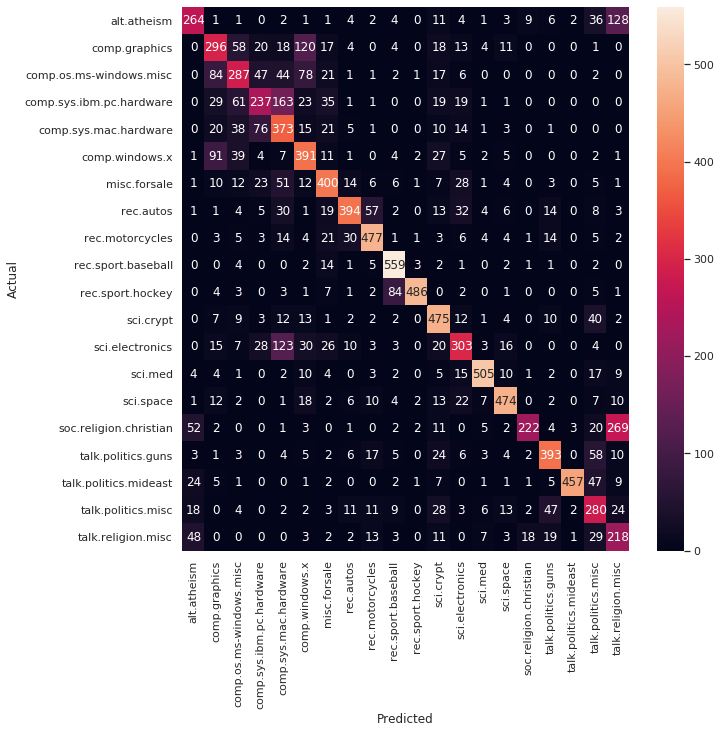

F1 score:  0.6653255479776238


In [32]:
model_lstm = evaluate_model(data, labels, X_test, y_test, rnn_layer='lstm', 
               recurrent_dropout=0.0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
Total params: 2,090,516
Trainable params: 90,516
Non-trainable params: 2,000,000
_________________________________________________________________
None
Train on 9051 samples, validate on 2263 samples
Epoch 1/4
9051/9051 [==============================] - 29s 3ms/step - loss: 0.1752 - acc: 0.9506 - val_loss: 0.1452 - val_acc: 0.9526
Epoch 2/4
9051/9051 [=============================

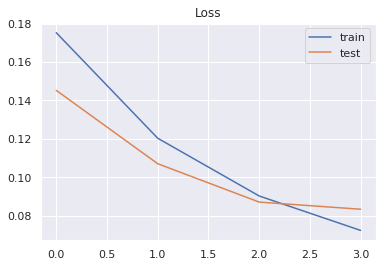

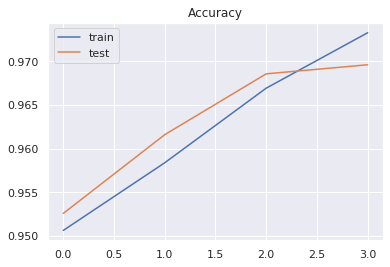

7532/7532 [==============================] - 5s 723us/step
Test set
  Loss: 0.311
  Accuracy: 0.934


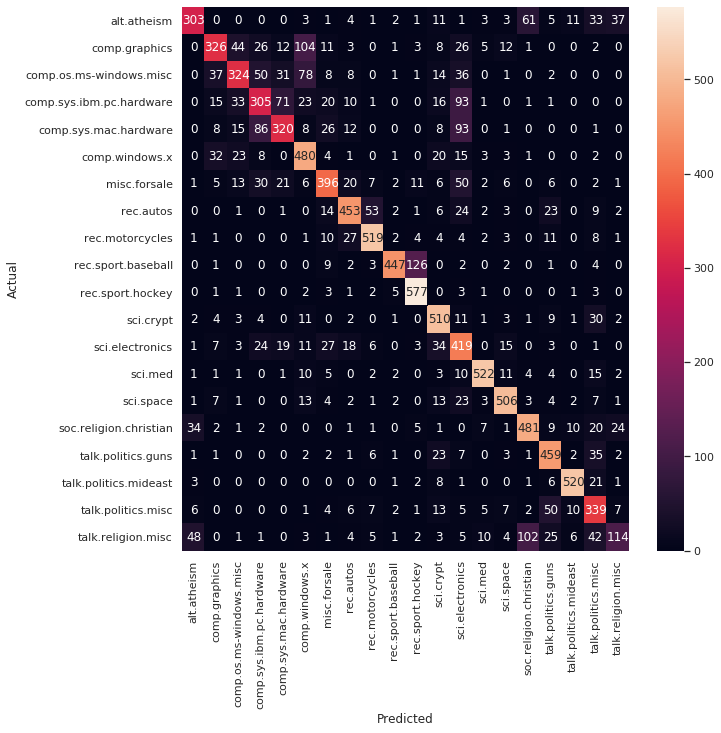

F1 score:  0.7316579443175733


In [33]:
model_gru = evaluate_model(data, labels, X_test, y_test, rnn_layer='gru', 
               recurrent_dropout=0.0)

## Recurrent Dropout

Now let's try to run the cells again but using the recurrent dropout parameter. Dropout removes some elements of one layers input at random. A common and important tool in recurrent neural networks is [_recurrent dropout_](https://arxiv.org/pdf/1512.05287.pdf). 

Just as regular dropout, recurrent dropout has a regularizing effect and can prevent overfitting. It is used in Keras by simply passing an argument to the LSTM or RNN layer. Recurrent Dropout, unlike regular dropout, does not have an own layer.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
Total params: 2,119,828
Trainable params: 119,828
Non-trainable params: 2,000,000
_________________________________________________________________
None
Train on 9051 samples, validate on 2263 samples
Epoch 1/4
9051/9051 [==============================] - 38s 4ms/step - loss: 0.1751 - acc: 0.9504 - val_loss: 0.1563 - val_acc: 0.9512
Epoch 2/4
9051/9051 [============================

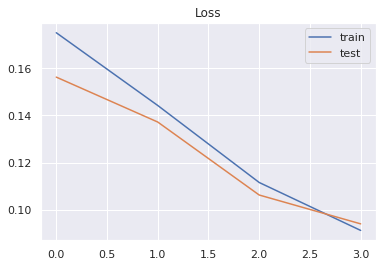

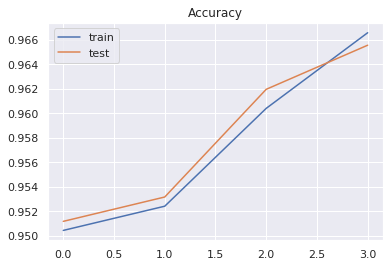

7532/7532 [==============================] - 7s 868us/step
Test set
  Loss: 0.260
  Accuracy: 0.943


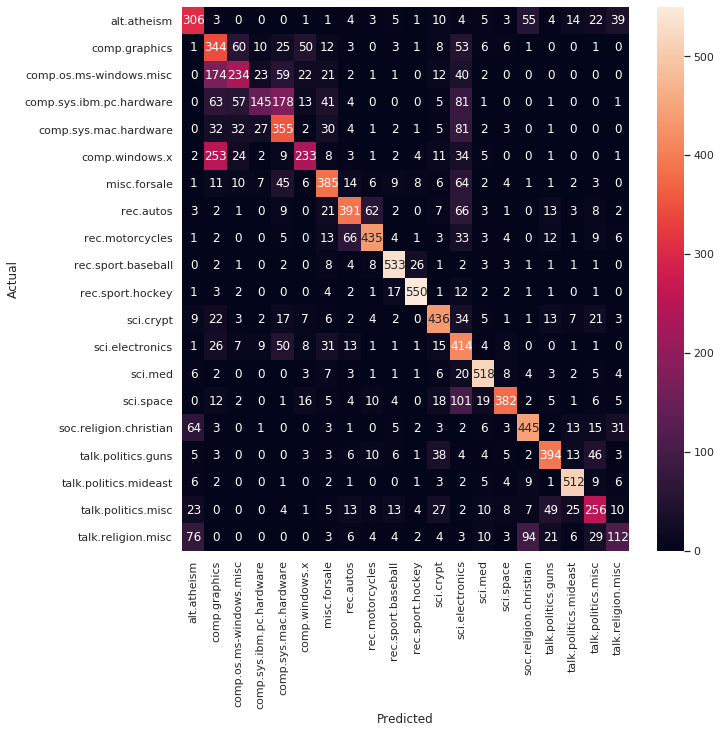

F1 score:  0.6498677301499884


In [34]:
model_lstm_dropout = evaluate_model(data, labels, X_test, y_test, rnn_layer='lstm', 
               recurrent_dropout=0.2)

In [0]:

model_gru = evaluate_model(data, labels, X_test, y_test, rnn_layer='gru', 
               recurrent_dropout=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
Total params: 2,090,516
Trainable params: 90,516
Non-trainable params: 2,000,000
_________________________________________________________________
None
Train on 9051 samples, validate on 2263 samples
Epoch 1/4
4512/9051 [=============>................] - ETA: 14s - loss: 0.1894 - acc: 0.9502

## Summary
In this notebook we have succesfully used Recurrent neural networks for the task of multitask text classification on for email classification. Also, we reviewed how the paradigm of the recurrent neural network is key for solving problems which deal with sequences. It is important to stand out the importance of improving the current paradigms, for example, this problem could be hardly solve with a simple recurrent neural network since the sequence of the model, as we watched in the plot, could be high, having the problem of the vanish gradient problem.

Angel.



In [0]:
# plot_confusion_matrix(model_gru, data, target, target_names)